In [ ]:
 #importe necessary libraries
 import numpy as np, matplotlib.pyplot as plt, seaborn as sns, time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
train_dir = "/content/drive/MyDrive/Lung Disease Dataset/train"
val_dir = "/content/drive/MyDrive/Lung Disease Dataset/val"
test_dir = "/content/drive/MyDrive/Lung Disease Dataset/test"

In [ ]:
IMAGE_SIZE = (240, 240)
BATCH_SIZE = 32
NUM_CLASSES = 5


train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.1,
                                   height_shift_range=0.1, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
val_generator = test_datagen.flow_from_directory(val_dir, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)


Found 6054 images belonging to 5 classes.
Found 2016 images belonging to 5 classes.
Found 2025 images belonging to 5 classes.


In [ ]:
#  DenseNet121 model
input_tensor = Input(shape=(240, 240, 3))
base_model = DenseNet121(include_top=False, weights='imagenet', input_tensor=input_tensor)
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
output_tensor = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs=input_tensor, outputs=output_tensor)

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
callbacks = [EarlyStopping(patience=5, restore_best_weights=True), ReduceLROnPlateau(patience=3)]

In [ ]:
start_time = time.time()
history = model.fit(train_generator, epochs=50, validation_data=val_generator, callbacks=callbacks)
print("Training Time: {:.2f} seconds".format(time.time() - start_time))

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 3664s 19s/step - accuracy: 0.6754 - loss: 0.8659 - val_accuracy: 0.6801 - val_loss: 0.7116 - learning_rate: 1.0000e-04
Epoch 2/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 141s 743ms/step - accuracy: 0.8655 - loss: 0.3504 - val_accuracy: 0.8874 - val_loss: 0.2831 - learning_rate: 1.0000e-04
Epoch 3/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 142s 746ms/step - accuracy: 0.8747 - loss: 0.3130 - val_accuracy: 0.8492 - val_loss: 0.3506 - learning_rate: 1.0000e-04
Epoch 4/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 142s 747ms/step - accuracy: 0.8935 - loss: 0.2647 - val_accuracy: 0.8135 - val_loss: 0.4245 - learning_rate: 1.0000e-04
Epoch 5/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 141s 743ms/step - accuracy: 0.9005 - loss: 0.2448 - val_accuracy: 0.6875 - val_loss: 0.8803 - learning_rate: 1.0000e-04
Epoch 6/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 140s 734ms/step - accuracy: 0.9053 - loss: 0.2259 - val_accuracy: 0.8700 - val_loss: 0.3008 - learning_rate: 1.0000e-05
Epoch 7/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 1

In [ ]:
model.save("/content/drive/MyDrive/densenet121_lung_model.h5")
np.save("/content/drive/MyDrive/densenet121_history.npy", history.history)

In [ ]:
loss, accuracy = model.evaluate(test_generator)
print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

64/64 ━━━━━━━━━━━━━━━━━━━━ 944s 15s/step - accuracy: 0.8750 - loss: 0.3381

Test Loss: 0.2833
Test Accuracy: 0.8795


In [ ]:
# Predictions
y_pred = model.predict(test_generator)
np.save("/content/drive/MyDrive/densenet121_preds.npy", y_pred)
y_pred_labels = np.argmax(y_pred, axis=1)
true_labels = test_generator.classes
class_names = list(test_generator.class_indices.keys())


64/64 ━━━━━━━━━━━━━━━━━━━━ 38s 449ms/step


Classification Report:

                      precision    recall  f1-score   support

 Bacterial Pneumonia     0.7619    0.7940    0.7776       403
Corona Virus Disease     0.9898    0.9582    0.9738       407
              Normal     0.9061    0.9554    0.9301       404
        Tuberculosis     0.9668    1.0000    0.9831       408
     Viral Pneumonia     0.7631    0.6873    0.7232       403

            accuracy                         0.8795      2025
           macro avg     0.8776    0.8790    0.8776      2025
        weighted avg     0.8780    0.8795    0.8781      2025



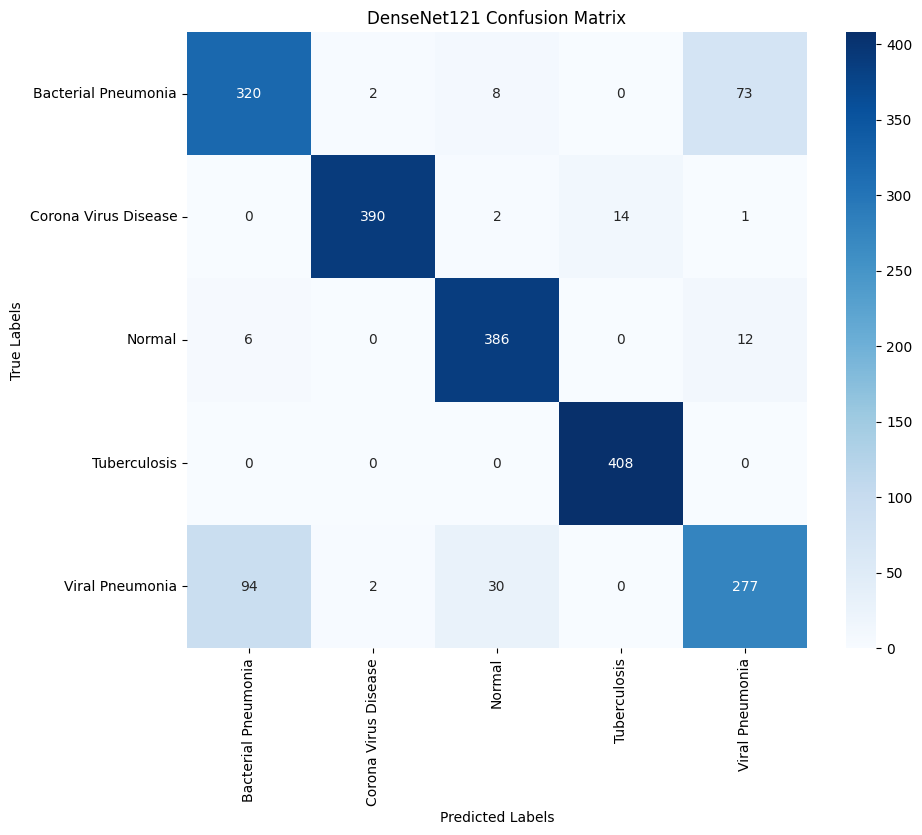

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Classification Report
print("Classification Report:\n")
print(classification_report(true_labels, y_pred_labels, target_names=class_names, digits=4))

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('DenseNet121 Confusion Matrix')
plt.show()

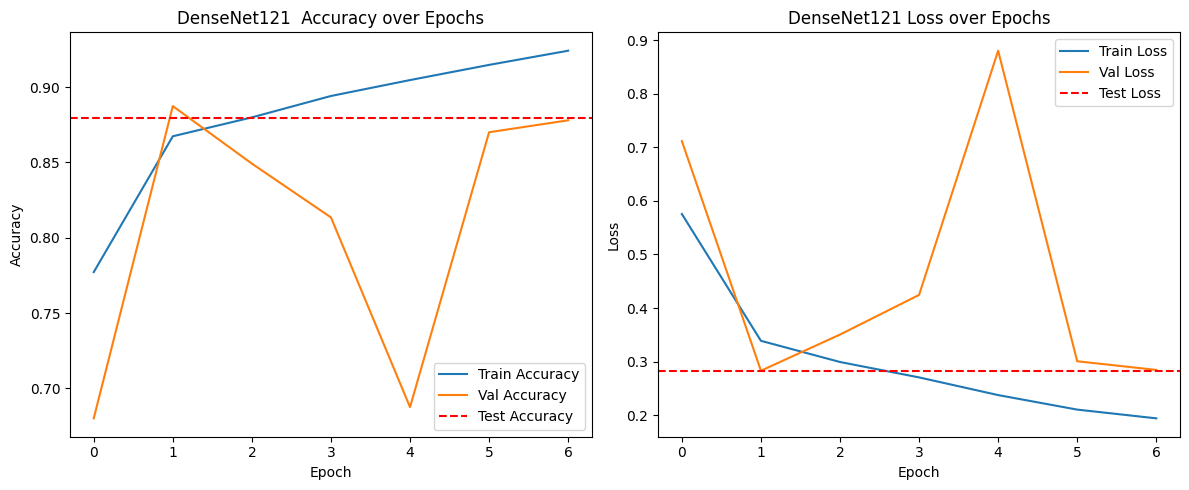

In [ ]:
#  Updated Plot Accuracy and Loss (with Test)
epochs_range = range(len(history.history['accuracy']))
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['accuracy'], label='Train Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Val Accuracy')
plt.axhline(y=accuracy, color='red', linestyle='--', label='Test Accuracy')
plt.title('DenseNet121  Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['loss'], label='Train Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Val Loss')
plt.axhline(y=loss, color='red', linestyle='--', label='Test Loss')
plt.title('DenseNet121 Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


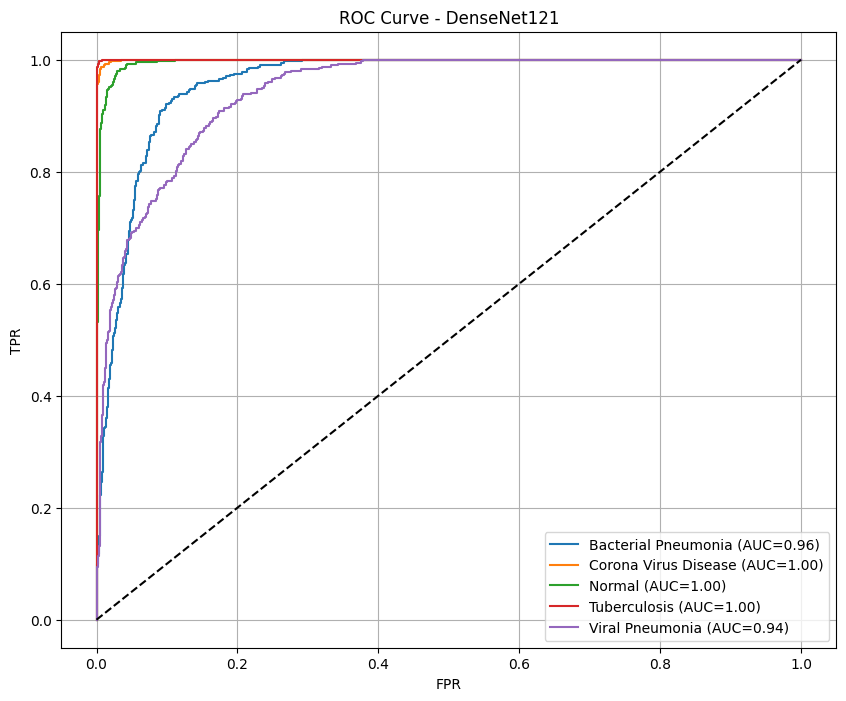

In [ ]:
#  ROC Curve
y_true_bin = label_binarize(true_labels, classes=range(NUM_CLASSES))
plt.figure(figsize=(10, 8))
for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC={roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--'); plt.title("ROC Curve - DenseNet121")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.grid(); plt.show()

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 240, 240,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 246, 246,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 120, 120,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 120, 120,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 120, 120,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 122, 122,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 60, 60,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 60, 60,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 60, 60,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 60, 60,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 60, 60,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 60, 60,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 60, 60,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 60, 60,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 60, 60,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 60, 60,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 60, 60,    │     12,288 │ conv2_block2_0_r

 Total params: 21,340,753 (81.41 MB)

 Trainable params: 7,085,701 (27.03 MB)

 Non-trainable params: 83,648 (326.75 KB)

 Optimizer params: 14,171,404 (54.06 MB)